In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from numpy import array
from datetime import datetime
import seaborn as sns

2022-10-09 16:24:37.800255: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-09 16:24:37.800280: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
sns.set_style("darkgrid")
cm = 1/2.54 
colors = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

### Replace missing values with Zero and Group by month

In [3]:
df = pd.read_csv('colheitas_sex.csv', parse_dates=['date'])
df = df.set_index('date')
df = df.groupby('sex').resample('M').sum()

### Create batches of training data (12 months)

In [4]:
def split_sequence(sequence, sequence_total, n_steps_in, n_steps_out, slide):
    X, y = list(), list()
    for i in range(0, len(sequence), slide):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence_total[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

### Define and fit MLP model 

In [5]:
def fit(X, y, n_steps_in, n_steps_out):
    callback = EarlyStopping(monitor='loss', patience=50)
    model = Sequential()
    model.add(Dense(800, activation='relu', input_shape=(n_steps_in,)))
    model.add(Dense(800, activation='relu', 
                kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-3),
                bias_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=500, verbose=1, callbacks=[callback])
    return model 

In [6]:
def train_predict(dataset, dataset_total, test, actual):
    n_steps_in, n_steps_out, slide = 6, 2, 1
    X, y = split_sequence(dataset, dataset_total, n_steps_in, n_steps_out, slide)
    
    # flatten input and output
    n_input = X.shape[1] * X.shape[2]
    X = X.reshape((X.shape[0], n_input))
    n_output = y.shape[1] * y.shape[2]
    y = y.reshape((y.shape[0], n_output))

    model = fit(X, y, n_input, n_output)      
    
    mae, rmse, smape = list(), list(), list()
    for i in range(0, len(test)-n_steps_in, n_steps_out):
        x_input = array(test[i:n_steps_in+i])
        x_input = x_input.reshape((1, n_input, 1))
        pred = model.predict(x_input)
        mae_aux, rmse_aux, smape_aux = measure_error(actual, pred[0], n_steps_in, n_steps_out, i)
        mae.append(mae_aux), rmse.append(rmse_aux), smape.append(smape_aux)
    
    return mae, rmse, smape

In [7]:
def sMAPE(actual, predicted):
    if not all([isinstance(actual, np.ndarray), 
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),
        np.array(predicted)
    return round(np.mean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual))/2))*100, 2)

In [8]:
def measure_error(actual, pred, step_in, step_out, index):
    #print(actual[index+step_in:index+step_in+step_out],pred,index+step_in,index+step_in+step_out)
    #print(len(actual[index+step_in:index+step_in+step_out]),len(pred))
    mae = mean_absolute_error(actual[index+step_in:index+step_in+step_out], pred)
    rmse = np.sqrt(mean_squared_error(actual[index+step_in:index+step_in+step_out], pred))
    smape = sMAPE(actual[index+step_in:index+step_in+step_out], pred)
    return mae, rmse, smape

### Normalize Data Set and Split Train and Test

In [9]:
df1 = df.pivot_table('nr', 'date', 'sex')
df1['Total'] = df1.sum(axis=1)

In [10]:
dataset = df1[['feminino','masculino']].values
dataset_total = df1[['Total']].values
mae, rmse, smape = train_predict(dataset[:216], dataset_total[:216], dataset[216:], df1[['Total']][216:].values)

Epoch 1/500


2022-10-09 16:24:39.501331: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-09 16:24:39.501369: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-09 16:24:39.501395: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-10-09 16:24:39.501779: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


7/7 [==============================] - 1s 15ms/step - loss: 89830760.0000
Epoch 2/500
7/7 [==============================] - 0s 12ms/step - loss: 17356914.0000
Epoch 3/500
7/7 [==============================] - 0s 10ms/step - loss: 12023328.0000
Epoch 4/500
7/7 [==============================] - 0s 12ms/step - loss: 8867690.0000
Epoch 5/500
7/7 [==============================] - 0s 11ms/step - loss: 6623362.0000
Epoch 6/500
7/7 [==============================] - 0s 11ms/step - loss: 5435185.5000
Epoch 7/500
7/7 [==============================] - 0s 12ms/step - loss: 4701724.0000
Epoch 8/500
7/7 [==============================] - 0s 11ms/step - loss: 4381770.0000
Epoch 9/500
7/7 [==============================] - 0s 11ms/step - loss: 4274060.0000
Epoch 10/500
7/7 [==============================] - 0s 12ms/step - loss: 4254252.5000
Epoch 11/500
7/7 [==============================] - 0s 12ms/step - loss: 3997967.5000
Epoch 12/500
7/7 [==============================] - 0s 14ms/step - loss:

7/7 [==============================] - 0s 10ms/step - loss: 3999034.7500
Epoch 97/500
7/7 [==============================] - 0s 11ms/step - loss: 3965163.2500
Epoch 98/500
7/7 [==============================] - 0s 11ms/step - loss: 3882768.0000
Epoch 99/500
7/7 [==============================] - 0s 10ms/step - loss: 3538532.7500
Epoch 100/500
7/7 [==============================] - 0s 11ms/step - loss: 3350225.5000
Epoch 101/500
7/7 [==============================] - 0s 13ms/step - loss: 3158269.7500
Epoch 102/500
7/7 [==============================] - 0s 13ms/step - loss: 2965219.2500
Epoch 103/500
7/7 [==============================] - 0s 11ms/step - loss: 2733501.2500
Epoch 104/500
7/7 [==============================] - 0s 12ms/step - loss: 2895800.7500
Epoch 105/500
7/7 [==============================] - 0s 13ms/step - loss: 2947160.7500
Epoch 106/500
7/7 [==============================] - 0s 12ms/step - loss: 2961448.0000
Epoch 107/500
7/7 [==============================] - 0s 11ms

7/7 [==============================] - 0s 12ms/step - loss: 2322150.5000
Epoch 191/500
7/7 [==============================] - 0s 10ms/step - loss: 2932298.7500
Epoch 192/500
7/7 [==============================] - 0s 13ms/step - loss: 2842064.2500
Epoch 193/500
7/7 [==============================] - 0s 11ms/step - loss: 3183822.0000
Epoch 194/500
7/7 [==============================] - 0s 11ms/step - loss: 2801895.2500
Epoch 195/500
7/7 [==============================] - 0s 12ms/step - loss: 2523140.0000
Epoch 196/500
7/7 [==============================] - 0s 11ms/step - loss: 2409002.5000
Epoch 197/500
7/7 [==============================] - 0s 10ms/step - loss: 2451553.2500
Epoch 198/500
7/7 [==============================] - 0s 12ms/step - loss: 2300346.5000
Epoch 199/500
7/7 [==============================] - 0s 12ms/step - loss: 2620414.5000
Epoch 200/500
7/7 [==============================] - 0s 11ms/step - loss: 2286774.7500
Epoch 201/500
7/7 [==============================] - 0s 1

7/7 [==============================] - 0s 12ms/step - loss: 1929291.6250
Epoch 285/500
7/7 [==============================] - 0s 11ms/step - loss: 1945358.1250
Epoch 286/500
7/7 [==============================] - 0s 11ms/step - loss: 2004052.3750
Epoch 287/500
7/7 [==============================] - 0s 12ms/step - loss: 2566825.7500
Epoch 288/500
7/7 [==============================] - 0s 11ms/step - loss: 2109412.5000
Epoch 289/500
7/7 [==============================] - 0s 12ms/step - loss: 1964367.2500
Epoch 290/500
7/7 [==============================] - 0s 11ms/step - loss: 1903341.1250
Epoch 291/500
7/7 [==============================] - 0s 16ms/step - loss: 1819066.5000
Epoch 292/500
7/7 [==============================] - 0s 14ms/step - loss: 1954321.0000
Epoch 293/500
7/7 [==============================] - 0s 14ms/step - loss: 1808446.1250
Epoch 294/500
7/7 [==============================] - 0s 12ms/step - loss: 1842528.6250
Epoch 295/500
7/7 [==============================] - 0s 1

7/7 [==============================] - 0s 12ms/step - loss: 1856457.5000
Epoch 379/500
7/7 [==============================] - 0s 12ms/step - loss: 1957535.7500
Epoch 380/500
7/7 [==============================] - 0s 11ms/step - loss: 2196745.2500
Epoch 381/500
7/7 [==============================] - 0s 11ms/step - loss: 1974710.5000
Epoch 382/500
7/7 [==============================] - 0s 12ms/step - loss: 1791996.0000
Epoch 383/500
7/7 [==============================] - 0s 11ms/step - loss: 1731056.8750
Epoch 384/500
7/7 [==============================] - 0s 12ms/step - loss: 1676465.2500
Epoch 385/500
7/7 [==============================] - 0s 13ms/step - loss: 1613190.6250
Epoch 386/500
7/7 [==============================] - 0s 10ms/step - loss: 1581026.6250
Epoch 387/500
7/7 [==============================] - 0s 11ms/step - loss: 1619136.2500
Epoch 388/500
7/7 [==============================] - 0s 11ms/step - loss: 1596790.2500
Epoch 389/500
7/7 [==============================] - 0s 1

7/7 [==============================] - 0s 12ms/step - loss: 1591119.0000
Epoch 473/500
7/7 [==============================] - 0s 14ms/step - loss: 1657560.7500
Epoch 474/500
7/7 [==============================] - 0s 15ms/step - loss: 1425980.6250
Epoch 475/500
7/7 [==============================] - 0s 12ms/step - loss: 1374070.8750
Epoch 476/500
7/7 [==============================] - 0s 12ms/step - loss: 1394863.5000
Epoch 477/500
7/7 [==============================] - 0s 12ms/step - loss: 1391169.8750
Epoch 478/500
7/7 [==============================] - 0s 13ms/step - loss: 1310836.8750
Epoch 479/500
7/7 [==============================] - 0s 12ms/step - loss: 1441951.7500
Epoch 480/500
7/7 [==============================] - 0s 13ms/step - loss: 1383990.5000
Epoch 481/500
7/7 [==============================] - 0s 13ms/step - loss: 1502273.8750
Epoch 482/500
7/7 [==============================] - 0s 13ms/step - loss: 1571190.6250
Epoch 483/500
7/7 [==============================] - 0s 1

In [11]:
len(mae)

15

### Calculate Error

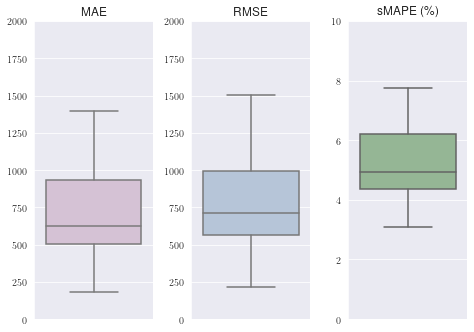

In [12]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(17*cm,12*cm))
sns.boxplot(ax=axes[0], y=mae, color='thistle', showfliers=False)
axes[0].set_title('MAE')
axes[0].set(ylim=(0, 2000))
sns.boxplot(ax=axes[1], y=rmse, color='lightsteelblue', showfliers=False)
axes[1].set_title('RMSE')
axes[1].set(ylim=(0, 2000))
sns.boxplot(ax=axes[2], y=smape, color='darkseagreen', showfliers=False)
axes[2].set_title('sMAPE (\%)')
axes[2].set(ylim=(0, 10))
plt.tight_layout()
#plt.savefig('figures/supply_mlp_monthly_sex_boxplot.pdf')

In [14]:
supply_mlp_month_sex = [mae,rmse,smape]
%store supply_mlp_month_sex 

Stored 'supply_mlp_month_sex' (list)
